In [27]:
import sys
import os
import matplotlib.pyplot as plt
sys.path.append("..")
from utils.train2 import *
device = 'cpu'

In [2]:
class CustomAtenttionRank(nn.Module):
    def __init__(self, n_features, n_classes, layers_list, activation=nn.ReLU(), dropout_list=None, batch_norm=True):
        super(CustomAtenttionRank, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.layers_list = layers_list
        self.activation = activation
        self.dropout_list = dropout_list
        self.batch_norm = batch_norm
        self.net = []
        self.b_list = []
        if self.dropout_list:
            self.dropout_list = [nn.Dropout(i) for i in self.dropout_list]
        for i in range(len(self.layers_list)):
            if self.batch_norm:
                self.b_list.append(nn.BatchNorm1d(self.layers_list[i]))
            if i==0:
                self.net.append(nn.Linear(self.n_features, self.layers_list[i]))
            else:
                self.net.append(nn.Linear(self.layers_list[i-1]+3, self.layers_list[i]))
        self.last_layer = nn.Linear(self.layers_list[-1]+self.n_features-3, self.n_classes)
        self.net = nn.ModuleList(self.net)
        self.prev_atenttion = nn.Linear(self.n_features-3, 3*(self.n_features-3))
        self.atenttion = nn.MultiheadAttention(self.n_features-3, 64, batch_first=True)
    
    def forward(self, x):
        b_size, _ = x.size()
        vp = torch.clone(x[:,-3:])
        embx = torch.clone(x[:,:-3])
        embx = self.prev_atenttion(embx)
        qkv = embx.view(b_size, 3, -1)
        q, k, v = qkv.chunk(3, dim = 1)
        out, _ = self.atenttion(q, k, v)
        out = out.squeeze(dim=1)
        for i, l in enumerate(self.net):
            #print(i)
            if i==0:
                x = self.activation(l(x))
            else:
                x = self.activation(l(torch.cat((x, vp), dim=1)))
            if self.batch_norm:
                x = self.b_list[i](x)
            if self.dropout_list:
                x = (self.dropout_list[i])(x)
            
        x = self.last_layer(torch.cat((x, out), dim=1))
        if self.n_classes == 1:
            x = torch.sigmoid(x)
   
        return nn.functional.softmax(x, dim = 0)

    def eval(self):
        self.train(False)
        for i in self.b_list:
            i.train(False)
    def cust_train(self):
        self.train(True)
        for i in self.b_list:
            i.train(True)

In [34]:
a = load_meta(os.path.join(os.pardir, 'metadata1'))

In [35]:
mod = CustomAtenttionRank(67, 512, [128, 128, 256, 256, 256], nn.GELU(), batch_norm=True)
print(mod)

CustomAtenttionRank(
  (activation): GELU()
  (last_layer): Linear(in_features=320, out_features=512, bias=True)
  (net): ModuleList(
    (0): Linear(in_features=67, out_features=128, bias=True)
    (1): Linear(in_features=131, out_features=128, bias=True)
    (2): Linear(in_features=131, out_features=256, bias=True)
    (3): Linear(in_features=259, out_features=256, bias=True)
    (4): Linear(in_features=259, out_features=256, bias=True)
  )
  (prev_atenttion): Linear(in_features=64, out_features=192, bias=True)
  (atenttion): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
)


In [36]:
optimizer = optim.SGD(mod.parameters(), lr = 0.1, momentum=0.9, weight_decay=1e-8, nesterov=True)

In [37]:
eo = trainRank(a, mod, optimizer, ep=500, save=True, prefix='marg')

E:\belugas_classification\notebooks\..\utils\train2.py:252: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vec_train = np.array([train_ids for train_ids,_ in skf.split(list(range(len(a.array))))])
E:\belugas_classification\notebooks\..\utils\train2.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vec_test = np.array([test_ids for _,test_ids in skf.split(list(range(len(a.array))))])
Loss: 0.251427610: 100%|████████████████████████████████| 500/500 [21:10<00:00,  2.54s/it, epoch_model=500, loss=0.251]


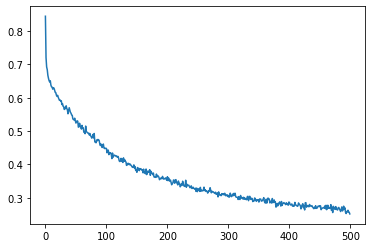

In [38]:
plt.plot(np.array(eo['loss']).reshape(-1, 1))